`April 13, 2022`

## **Time Series Forecasting**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('shampoo_sales.csv')
df.tail()

,Month,Sales
31,3-08,407.6
32,3-09,682.0
33,3-10,475.3
34,3-11,581.3
35,3-12,646.9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   36 non-null     object 
 1   Sales   36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 704.0+ bytes


In [4]:
df_shampoo = df.copy()
df_shampoo['Month'] = df_shampoo['Month'].apply(lambda x: '200' + x)
df_shampoo['Month'] = pd.to_datetime(df_shampoo['Month'])

In [5]:
df_shampoo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   36 non-null     datetime64[ns]
 1   Sales   36 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 704.0 bytes


In [6]:
df_shampoo.head()

,Month,Sales
0,2001-01-01,266.0
1,2001-02-01,145.9
2,2001-03-01,183.1
3,2001-04-01,119.3
4,2001-05-01,180.3


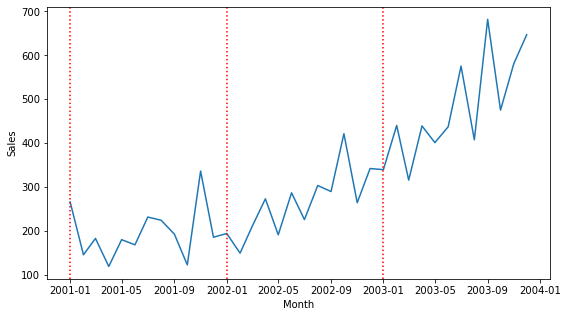

In [7]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.lineplot(x='Month', y='Sales', data=df_shampoo, ax=ax)
plt.axvline(pd.to_datetime('2001-01-01'), ls=':', color='red')
plt.axvline(pd.to_datetime('2002-01-01'), ls=':', color='red')
plt.axvline(pd.to_datetime('2003-01-01'), ls=':', color='red');

### **Decomposition**

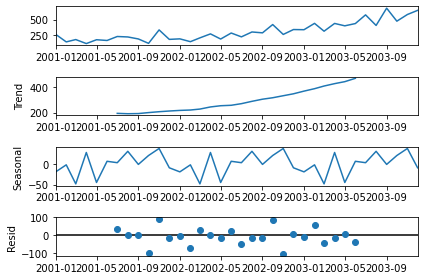

In [8]:
df_shampoo_index = df_shampoo.set_index('Month')
shampoo_decomposition = seasonal_decompose(df_shampoo_index)
shampoo_decomposition.plot();

### **Differencing**

In [9]:
df_shampoo.head()

,Month,Sales
0,2001-01-01,266.0
1,2001-02-01,145.9
2,2001-03-01,183.1
3,2001-04-01,119.3
4,2001-05-01,180.3


In [10]:
# Differencing level 1 (1st order differencing)
df_shampoo['Sales_Lag1'] = df_shampoo['Sales'].shift(1)
df_shampoo['Sales_Diff1'] = df_shampoo['Sales'] - df_shampoo['Sales_Lag1']

# Differencing level 2 (2nd order differencing)
df_shampoo['Sales_Diff1_Lag1'] = df_shampoo['Sales_Diff1'].shift(1)
df_shampoo['Sales_Diff2'] = df_shampoo['Sales_Diff1'] - df_shampoo['Sales_Diff1_Lag1']
df_shampoo.head()

,Month,Sales,Sales_Lag1,Sales_Diff1,Sales_Diff1_Lag1,Sales_Diff2
0,2001-01-01,266.0,NaN,NaN,NaN,NaN
1,2001-02-01,145.9,266.0,-120.1,NaN,NaN
2,2001-03-01,183.1,145.9,37.2,-120.1,157.3
3,2001-04-01,119.3,183.1,-63.8,37.2,-101.0
4,2001-05-01,180.3,119.3,61.0,-63.8,124.8


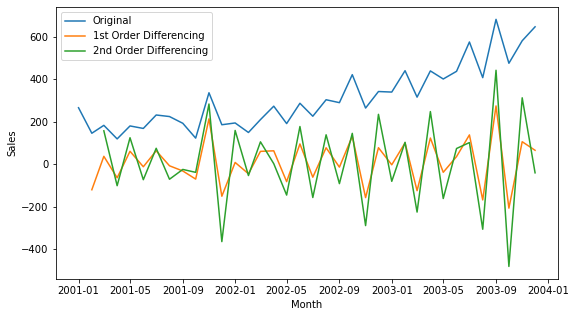

In [11]:
plt.figure(figsize=(9, 5))
sns.lineplot(x='Month', y='Sales', data=df_shampoo, label='Original')
sns.lineplot(x='Month', y='Sales_Diff1', data=df_shampoo, label='1st Order Differencing')
sns.lineplot(x='Month', y='Sales_Diff2', data=df_shampoo, label='2nd Order Differencing');

`Statistical test`

In [12]:
# Statistical test to validate stationarity

# Ho = The data is not stationary
# Ha = The data is stationary

alpha = 0.05
adfuller_pvalue = adfuller(df_shampoo['Sales_Diff1'].dropna())[1]

if adfuller_pvalue <= alpha:
    print('Reject Ho. The data is stationary')
    print(adfuller_pvalue)
else:
    print('Fail to reject Ho. The data is not stationary')
    print(adfuller_pvalue)

Reject Ho. The data is stationary
1.7998574141687034e-10


Conclusion: We only need one time differencing to get our data to be stationary.

### **ACF & PACF Plot**

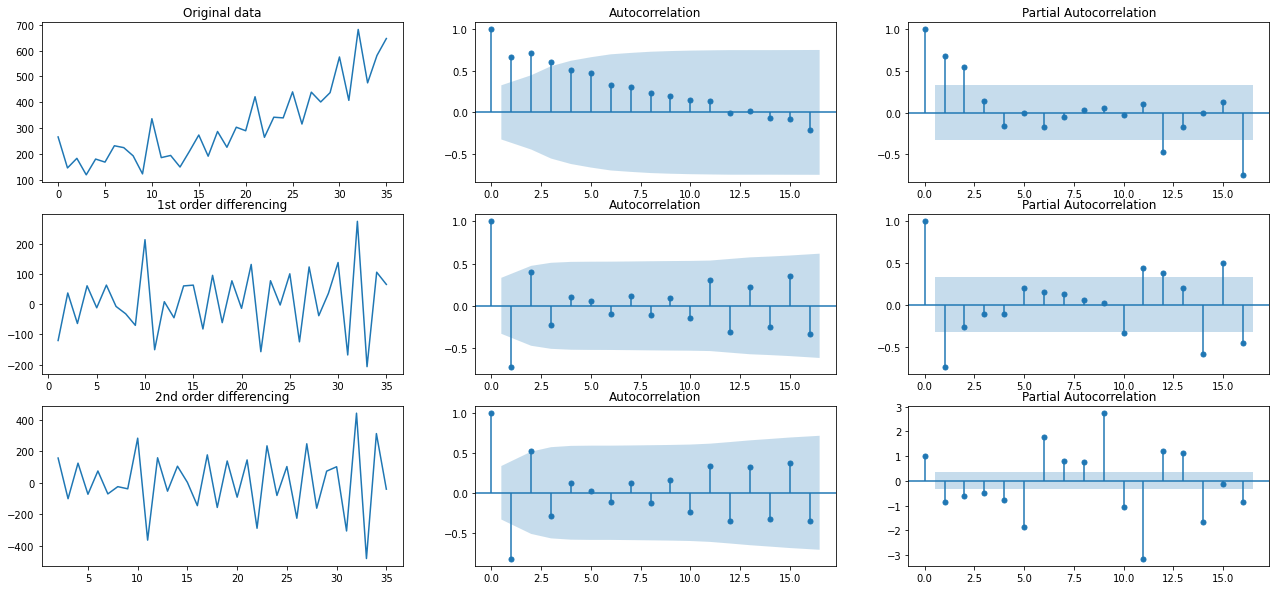

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(22, 10))

# Original data
ax[0, 0].plot(df_shampoo['Sales'])
ax[0, 0].set_title('Original data')
plot_acf(df_shampoo['Sales'], ax=ax[0, 1])
plot_pacf(df_shampoo['Sales'], ax=ax[0, 2])

# 1st order differencing
ax[1, 0].plot(df_shampoo['Sales_Diff1'])
ax[1, 0].set_title('1st order differencing')
plot_acf(df_shampoo['Sales_Diff1'].dropna(), ax=ax[1, 1])
plot_pacf(df_shampoo['Sales_Diff1'].dropna(), ax=ax[1, 2])

# 2nd order differencing
ax[2, 0].plot(df_shampoo['Sales_Diff2'])
ax[2, 0].set_title('2nd order differencing')
plot_acf(df_shampoo['Sales_Diff2'].dropna(), ax=ax[2, 1])
plot_pacf(df_shampoo['Sales_Diff2'].dropna(), ax=ax[2, 2]);

    p: 1
    d: 1
    q: 1

    ARIMA (1, 1, 0) atau ARIMA(0, 1, 1)

### **ARIMA model**

In [14]:
df_shampoo_index.head()

,Sales
Month,
2001-01-01,266.0
2001-02-01,145.9
2001-03-01,183.1
2001-04-01,119.3
2001-05-01,180.3


`Modeling`

In [15]:
arima = ARIMA(endog=df_shampoo_index, order=(1, 1, 0))
arima_fit = arima.fit()

In [16]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -201.287
Date:                Thu, 14 Apr 2022   AIC                            406.575
Time:                        10:19:30   BIC                            409.686
Sample:                    01-01-2001   HQIC                           407.649
                         - 12-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7142      0.136     -5.259      0.000      -0.980      -0.448
sigma2      5683.4514   1448.557      3.924      0.000    2844.331    8522.572
Ljung-Box (L1) (Q):                   1.89   Jarque-

In [17]:
arima_fit.fittedvalues

Month
2001-01-01      0.000000
2001-02-01    263.821085
2001-03-01    231.679270
2001-04-01    156.530568
2001-05-01    164.868005
2001-06-01    136.731845
2001-07-01    176.927938
2001-08-01    186.589111
2001-09-01    229.713894
2001-10-01    215.441156
2001-11-01    172.824821
2001-12-01    183.940033
2002-01-01    293.463347
2002-02-01    188.300451
2002-03-01    181.497596
2002-04-01    166.817538
2002-05-01    228.160534
2002-06-01    249.895605
2002-07-01    218.719416
2002-08-01    269.568155
2002-09-01    248.175593
2002-10-01    299.684979
2002-11-01    327.535639
2002-12-01    376.705856
2003-01-01    286.732746
2003-02-01    341.557003
2003-03-01    368.476832
2003-04-01    404.821891
2003-05-01    351.163765
2003-06-01    428.440818
2003-07-01    411.616223
2003-08-01    476.864553
2003-09-01    527.519562
2003-10-01    486.014725
2003-11-01    622.931765
2003-12-01    505.591402
dtype: float64

In [18]:
df_shampoo['Sales_Predicted'] = arima_fit.fittedvalues.values
df_shampoo.head()

,Month,Sales,Sales_Lag1,Sales_Diff1,Sales_Diff1_Lag1,Sales_Diff2,Sales_Predicted
0,2001-01-01,266.0,NaN,NaN,NaN,NaN,0.000000
1,2001-02-01,145.9,266.0,-120.1,NaN,NaN,263.821085
2,2001-03-01,183.1,145.9,37.2,-120.1,157.3,231.679270
3,2001-04-01,119.3,183.1,-63.8,37.2,-101.0,156.530568
4,2001-05-01,180.3,119.3,61.0,-63.8,124.8,164.868005


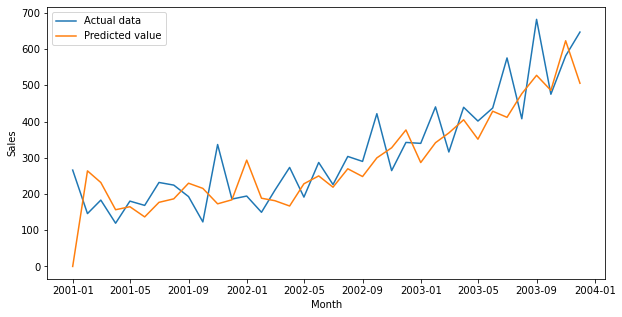

In [19]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='Month', y='Sales', data=df_shampoo, label='Actual data')
sns.lineplot(x='Month', y='Sales_Predicted', data=df_shampoo, label='Predicted value');

`Forecasting`

In [20]:
forecast_one_year = arima_fit.forecast(6)
forecast_one_year

2004-01-01    600.046377
2004-02-01    633.510736
2004-03-01    609.609419
2004-04-01    626.680506
2004-05-01    614.487788
2004-06-01    623.196218
Freq: MS, Name: predicted_mean, dtype: float64

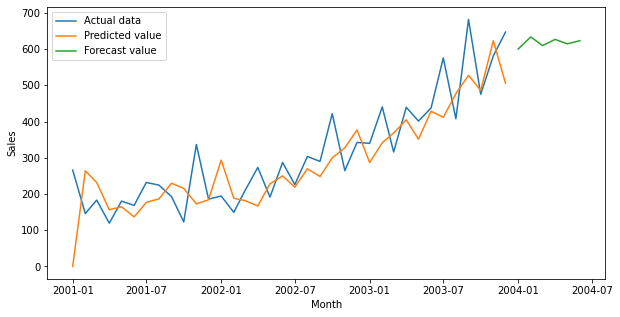

In [21]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='Month', y='Sales', data=df_shampoo, label='Actual data')
sns.lineplot(x='Month', y='Sales_Predicted', data=df_shampoo, label='Predicted value')
sns.lineplot(x=forecast_one_year.index, y=forecast_one_year.values, label='Forecast value');

### **Model evaluation**

In [29]:
df_shampoo_new = df_shampoo[['Month', 'Sales']].copy()

# Train & test set
df_shampoo_train = df_shampoo_new[df_shampoo_new['Month'] < '2003-07-01'].set_index('Month')
df_shampoo_test = df_shampoo_new[df_shampoo_new['Month'] >= '2003-07-01'].set_index('Month')

In [30]:
df_shampoo_train.head()

,Sales
Month,
2001-01-01,266.0
2001-02-01,145.9
2001-03-01,183.1
2001-04-01,119.3
2001-05-01,180.3


In [32]:
shampoo_freq = df_shampoo_train.index.inferred_freq

arima = ARIMA(endog=df_shampoo_train, order=(1, 1, 0), freq=shampoo_freq)
arima_fit = arima.fit()

In [33]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   30
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -162.402
Date:                Thu, 14 Apr 2022   AIC                            328.805
Time:                        10:27:32   BIC                            331.539
Sample:                    01-01-2001   HQIC                           329.661
                         - 06-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6854      0.165     -4.163      0.000      -1.008      -0.363
sigma2      4196.3972   1164.311      3.604      0.000    1914.390    6478.404
Ljung-Box (L1) (Q):                   0.21   Jarque-

In [36]:
df_shampoo_train['Sales_fitted'] = arima_fit.fittedvalues.values
df_shampoo_train['Error'] = df_shampoo_train['Sales_fitted'] - df_shampoo_train['Sales']

In [37]:
# RMSE
np.sqrt(mean_squared_error(
                    df_shampoo_train['Sales'],
                    df_shampoo_train['Sales_fitted']))

81.41736583100717

In [41]:
# MAE
mean_absolute_error(df_shampoo_train['Sales'], df_shampoo_train['Sales_fitted'])

61.66912319494012

In [39]:
# R-squared
r2_score(df_shampoo_train['Sales'], df_shampoo_train['Sales_fitted'])

0.2822178243352418

In [40]:
# Forecast
forecast_6months = arima_fit.forecast(6)
df_shampoo_test['Sales forecasted'] = forecast_6months
df_shampoo_test

,Sales,Sales forecasted
Month,,
2003-07-01,575.5,412.657884
2003-08-01,407.6,429.615566
2003-09-01,682.0,417.993158
2003-10-01,475.3,425.958891
2003-11-01,581.3,420.499359
2003-12-01,646.9,424.241197


`Test set`

In [43]:
# RMSE test set
np.sqrt(mean_squared_error(
                    df_shampoo_test['Sales'],
                    df_shampoo_test['Sales forecasted']))

170.57265620050586

In [44]:
mean_absolute_error(df_shampoo_test['Sales'], df_shampoo_test['Sales forecasted'])

146.94417946020164

In [45]:
# R-squared
r2_score(df_shampoo_test['Sales'], df_shampoo_test['Sales forecasted'])

-2.2619531560042185

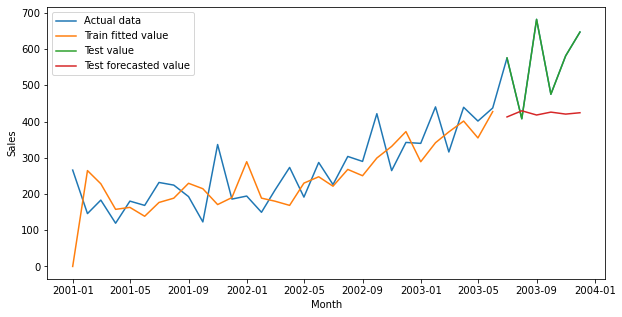

In [46]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='Month', y='Sales', data=df_shampoo, label='Actual data')
sns.lineplot(x='Month', y='Sales_fitted', data=df_shampoo_train, label='Train fitted value')
sns.lineplot(x='Month', y='Sales', data=df_shampoo_test, label='Test value')
sns.lineplot(x='Month', y='Sales forecasted', data=df_shampoo_test, label='Test forecasted value');
